In [3]:
import pandas as pd
pd.set_option('display.max_rows', 500)
import numpy as np
from nelson_siegel_svensson import NelsonSiegelSvenssonCurve, NelsonSiegelCurve
from nelson_siegel_svensson.calibrate import calibrate_ns_ols
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data = pd.read_csv('libor-rate-historical-chart.csv').tail(365)
data['rate'] = data['rate'] / 100
data.shape

(365, 2)

In [5]:
t = np.array(range(0,365))/12
y = data['rate'].values

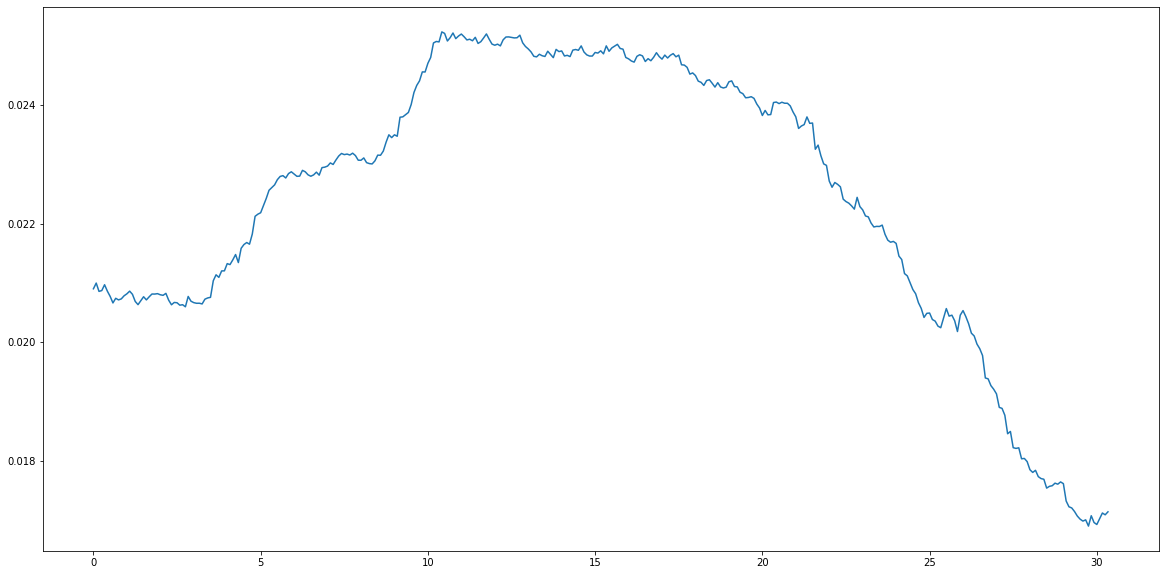

In [6]:
plt.figure(figsize=(20,10))
plt.plot(t, y)
plt.show()

In [16]:
for i in range(0,500):
    try:
        curve, status = calibrate_ns_ols(t, y, tau0=i)  # starting value of 1.0 for the optimization of tau
        assert status.success, 'Fail to optimize'
        print(curve)
        break
    except:
        pass

NelsonSiegelCurve(beta0=0.022492416527679183, beta1=-0.0015894165276711062, beta2=-6.115379935038244, tau=5.1259016953242777e-05)


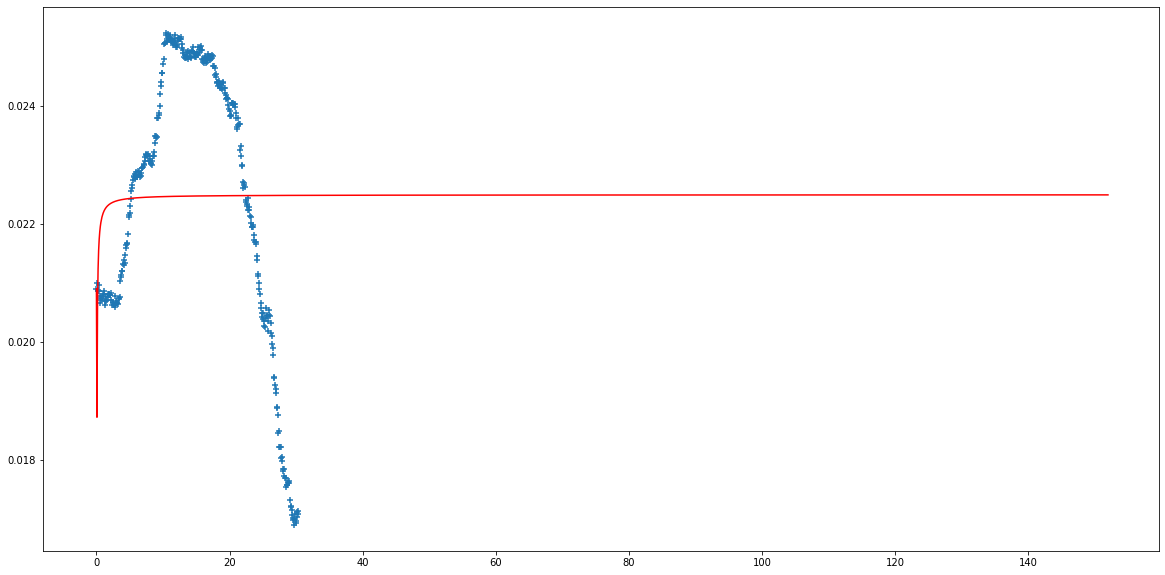

In [17]:
plt.figure(figsize=(20,10))
t_foward = np.array(range(0,365*5))/12
plt.plot(t_foward, curve(t_foward), c='red')
plt.scatter(t, y, marker='+')
plt.show()